In [45]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys
import h5py
from torch.optim import lr_scheduler


sys.path.append("../../")
from metric import *
from util import *
from model.pinn import PINNs, MLP


In [46]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [47]:
# get data
# 几何区域：-1<=x<=1, 0<=t<=0.6
# 均匀网格离散化：101*101
# res: 所有散点坐标
X_SIZE = 101
T_SIZE = 101

res, b_init, b_end, b_left, b_right = get_data([-1, 1], [0, 0.6], X_SIZE, T_SIZE) 
res_test, _, _, _, _ = get_data([-1, 1], [0, 0.6], X_SIZE, T_SIZE) 

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_init = torch.tensor(b_init, dtype=torch.float32, requires_grad=True).to(device)  # init
b_end = torch.tensor(b_end, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)  # right
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)  # left

# 分别提取散点的x t坐标 --> 列表
x_res, t_res = res[:,0:1], res[:,1:2]
x_init, t_init = b_init[:,0:1], b_init[:,1:2]
x_end, t_end = b_end[:,0:1], b_end[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]

# 有限体积采样边界点
DFVM_solver = DFVMsolver(1, device)
X_inL, X_inR = DFVM_solver.get_vol_data2(res)
X_inL  = X_inL.requires_grad_(True).to(device)  # 内部点的CV边界采样点
X_inR  = X_inR.requires_grad_(True).to(device)

print('x_inL: ', X_inL.shape)

print('res shape: ', res.shape, 'b_left shape: ', b_left.shape, 'b_right shape: ', b_right.shape, 'b_upper shape: ', b_init.shape, 'b_lower shape: ', b_end.shape)

x_inL:  torch.Size([10201, 2])
res shape:  torch.Size([10201, 2]) b_left shape:  torch.Size([101, 2]) b_right shape:  torch.Size([101, 2]) b_upper shape:  torch.Size([101, 2]) b_lower shape:  torch.Size([101, 2])


In [48]:
# Train PINNs -- MLP
model = PINNs(in_dim=2, hidden_dim=128, out_dim=1, num_layer=8).to(device)

model.apply(init_weights)
# optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = lr_scheduler.ExponentialLR(optim, gamma=0.9, verbose=True)

print(model)
print(get_n_params(model))  # 总的参数量

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=1, bias=True)
  )
)
99585


/tmp/ipykernel_844359/3342654418.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [49]:
loss_track = []
model.train()
step_size = 5000

def jacobian(y, x, i, j):
    '''
    input: y[], x[]
    '''
    y = y[:,i]
    grad = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0][:,j]  # y 相对于 x 的第 j 维的偏导数
    return grad.reshape(-1, 1)

def pde_burgers1D(x, model, nu):
    '''
    u_t + uu_x = 0

    input: x:[x, xL, xR] [内部点、CV左边界点、CV右边界点]
    '''
    x, t, xL, xR = x
    y = model(x, t)
    # print('in pde: ', y.shape, x.shape)
    dy_x = jacobian(y, x, i=0, j=0)
    dy_t = jacobian(y, t, i=0, j=0)
    yL = model(xL[:, 0:1], t)
    yR = model(xR[:, 0:1], t)
    dyR_x = jacobian(yR, xR, i=0, j=0)
    dyL_x = jacobian(yL, xL, i=0, j=0)
    res = (dy_t + y * dy_x)*0.0002 - nu*(dyR_x - dyL_x)  # 控制体积守恒性质
    
    return res.reshape(-1, 1)


pde = lambda x, model: pde_burgers1D(x, model, 0.001)
for i in tqdm(range(1000)):
    optim.zero_grad()
    
    pred_init = model(x_init, t_init)  # init
    pred_left = model(x_left, t_left)  # right
    pred_right = model(x_right, t_right)  # left
    
    loss_res = torch.mean(pde((x_res, t_res, X_inL,X_inR), model)**2)
    loss_ic = torch.mean(torch.where(x_init <= 0, (pred_init-1) ** 2, pred_init ** 2))  # 初值：u(x, 0) = 1, x<=0; u(x, 0) = 0, x>0
    loss_bc = torch.mean((pred_left - 1) ** 2 + (pred_right) ** 2)

    loss = loss_res + 100*loss_ic + loss_bc
    
    loss.backward()  # 反向传播

    optim.step()  # 参数更新

    if (i+1) % step_size == 0:
        scheduler.step()

    with torch.no_grad():
        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])
    
    if i % 5000 == 0:
        print('Iter %d, res: %.5e, Lossic: %.5e, Lossbc: %.5e' % (i, loss_res.item(), loss_ic.item(), loss_bc.item()))

  1%|          | 6/1000 [00:00<00:19, 51.28it/s]

Iter 0, res: 5.23634e-12, Lossic: 5.14551e-01, Lossbc: 9.54570e-01


100%|██████████| 1000/1000 [00:27<00:00, 36.90it/s]


In [50]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000000, Loss_BC: 0.000002, Loss_IC: 0.000009
Train Loss: 0.000012


In [57]:
import pandas as pd
import numpy as np
import os

def write_res(metrics, filename, tag, append=True):
    # 创建DataFrame
    df = pd.DataFrame()

    # 获取第一个度量值列表的长度来确定维度
    _, values = next(iter(metrics.items()))
    dim = len(values)

    # 遍历metrics字典中的所有度量值
    for metric, values in metrics.items():
        values = [x.item() if hasattr(x, 'item') else x for x in values]  # 处理可能存在的tensor
        if "field" not in df.columns:
            if dim > 1:
                df.insert(0, 'field', [tag + "_x" + str(k) for k in range(dim)] + [tag + "_mean"] + [tag + "_global"])
            else:
                df.insert(0, 'field', [tag + "_x" + str(k) for k in range(dim)])

        if dim > 1:
            df[metric] = [*values] + [np.mean(values)] + [np.nan]  # 假设没有全局值
        else:
            df[metric] = [*values]

    # 如果有平均推理时间或其他额外信息，可以在这里添加
    # if "Mean inference time" in metrics:
    #     df["Mean inference time"] = [metrics["Mean inference time"]]*len(df)

    # 写入CSV文件
    if append:
        if os.path.exists(filename):
            df.to_csv(filename, mode='a', header=False, index=False)
        else:
            df.to_csv(filename, index=False)
    else:
        df.to_csv(filename, index=False)

# 示例调用
metrics = {
    'model_name': ['ModelB'],
    'RL1': [0.95],
    'RL2': [0.97],
    'L2RE': [0.05],
    'MaxE': [0.1],
    'MSE': [0.005],
    'RMSE': [0.07]
}
# write_res(metrics, './output.csv', 'test_tag')

torch.Size([10201, 1])
(101, 101)
{'model_name': ['DFVM'], 'RL1': [0.10785316996125027], 'RL2': [0.31371369075715483], 'L2RE': [tensor(9.7736)], 'MaxE': [tensor(0.1422)], 'MSE': [tensor(0.0565)], 'RMSE': [tensor(0.0619)]}


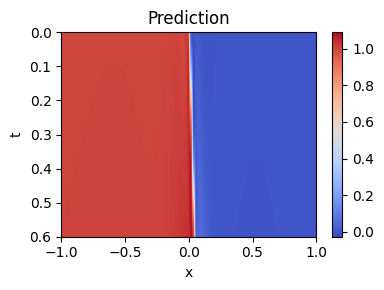

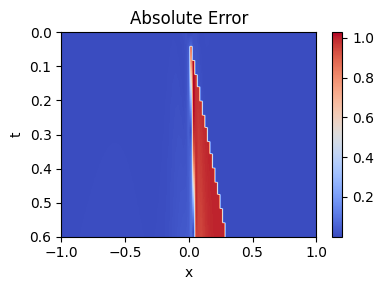

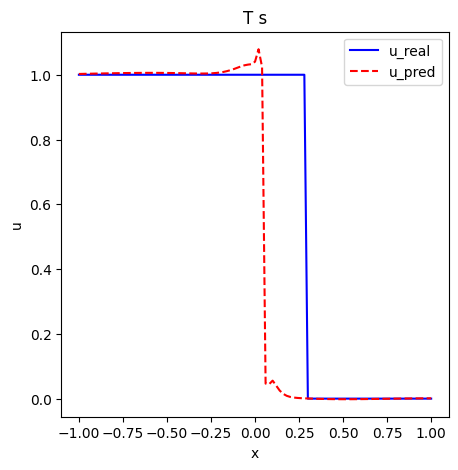

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def save_fig(res_test, folder_name, model_name, X_SIZE, T_SIZE, label_path='./burgers_move.mat'):

    res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
    x_test, t_test = res_test[:,0:1], res_test[:,1:2]
    print(t_test.shape)

    mat = scipy.io.loadmat(label_path)
    u = mat['u'].reshape(X_SIZE, T_SIZE)

    with torch.no_grad():
        pred = model(x_test, t_test)[:,0:1]
        pred = pred.cpu().detach().numpy()
    pred = pred.reshape(X_SIZE, T_SIZE)

    print(pred.shape)

    rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))
    L2re = L2RE(torch.tensor(u), torch.tensor(pred)).mean()
    MaxE = MaxError(torch.tensor(u), torch.tensor(pred)).mean()
    Mse = MSE(torch.tensor(u), torch.tensor(pred)).mean()
    Rmse = RMSE(torch.tensor(u), torch.tensor(pred)).mean()
    metrics = {
    'model_name': [model_name],
    'RL1': [rl1],
    'RL2': [rl2],
    'L2RE': [L2re],
    'MaxE': [MaxE],
    'MSE': [Mse],
    'RMSE': [Rmse]}
    df = pd.DataFrame(metrics)
    df.to_csv('evaluation_metrics.csv', index=False)
    print(metrics)

    if not os.path.exists(f'./image/{folder_name}'):
        os.makedirs(f'./image/{folder_name}')

    plt.figure(figsize=(4,3))
    plt.imshow(pred, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Prediction')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f'./image/{folder_name}/{model_name}_pred.png')

    plt.figure(figsize=(4,3))
    plt.imshow(np.abs(pred - u), extent=[-1, 1, 0.6, 0], aspect='auto',  cmap='coolwarm')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Absolute Error')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f'./image/{folder_name}/{model_name}_error.png')

    # 绘制t时刻的折线图
    x = np.linspace(-1, 1, X_SIZE)
    u_real = u[-1, :]
    u_pred = pred[-1, :] 

    plt.figure(figsize=(5, 5))
    plt.plot(x, u_real, label='u_real', color='blue')  # 实际值曲线
    plt.plot(x, u_pred, label='u_pred', color='red', linestyle='--')  # 预测值曲线
    plt.title('T s')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(False)
    plt.savefig(f'./image/{folder_name}/{model_name}_T.png')

folder_name = '1000'
model_name = 'DFVM'
save_fig(res_test, folder_name, model_name, X_SIZE, T_SIZE, label_path='./burgers_move.mat')

In [2]:
0.6/2 * 202

60.599999999999994

In [52]:
# # Visualize PINNs 
# res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
# x_test, t_test = res_test[:,0:1], res_test[:,1:2]
# print(t_test.shape)

# mat = scipy.io.loadmat('./burgers_move.mat')
# u = mat['u'].reshape(X_SIZE, T_SIZE)

# with torch.no_grad():
#     pred = model(x_test, t_test)[:,0:1]
#     pred = pred.cpu().detach().numpy()
# pred = pred.reshape(X_SIZE, T_SIZE)

# print(pred.shape)

# rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
# rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))
# print('relative L1 error: {:4f}'.format(rl1))
# print('relative L2 error: {:4f}'.format(rl2))

# L2re = L2RE(torch.tensor(u), torch.tensor(pred)).mean()
# MaxE = MaxError(torch.tensor(u), torch.tensor(pred)).mean()
# Mse = MSE(torch.tensor(u), torch.tensor(pred)).mean()
# Rmse = RMSE(torch.tensor(u), torch.tensor(pred)).mean()
# print("MSE: ", Mse.detach().cpu().numpy())
# print("RMSE: ", Rmse.detach().cpu().numpy())
# print("L2RE: ", L2re.detach().cpu().numpy())
# print("MaxE: ", MaxE.detach().cpu().numpy())


# plt.figure(figsize=(4,3))
# plt.imshow(pred, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('Prediction')
# plt.colorbar()
# plt.tight_layout()
# plt.savefig('./image/newlayer_30000/dfvm_pred.png')
# plt.show()

# # 5000次学到的是稍微move一点（方向正确）
# # 10000次学到的是稍微move一点（方向正确）
# # 30000次学到了错误的移动

# # 30000次 - newlayer 学到了正确的激波位置
# # relative L1 error: 0.012138
# # relative L2 error: 0.093352
# # MSE:  0.0050043897
# # RMSE:  0.00697051
# # L2RE:  3.6744602
# # MaxE:  0.12557389

# # 100000次 - newlayer 没学到正确的激波位置
# # relative L1 error: 0.114282
# # relative L2 error: 0.329207
# # MSE:  0.06223636
# # RMSE:  0.06562748
# # L2RE:  472.11273
# # MaxE:  0.14218858

In [53]:
# plt.figure(figsize=(4,3))
# plt.imshow(u, extent=[-1, 1, 0.6, 0], aspect='auto',  cmap='coolwarm')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('Exact u(x,t)')
# plt.colorbar()
# plt.tight_layout()
# plt.savefig('./image/exact.png')
# plt.show()

In [54]:
# plt.figure(figsize=(4,3))
# plt.imshow(np.abs(pred - u), extent=[-1, 1, 0.6, 0], aspect='auto',  cmap='coolwarm')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('Absolute Error')
# plt.colorbar()
# plt.tight_layout()
# plt.savefig('./image/newlayer_30000/dfvm_error.png')
# plt.show()

In [55]:
# # 绘制t时刻的折线图
# print(u.shape)
# import matplotlib.pyplot as plt
# import numpy as np

# # 假设的时间序列数据
# x = np.linspace(-1, 1, 101)
# u_real = u[-1, :]  # 实际值，例如使用正弦波
# u_pred = pred[-1, :]  # 预测值，添加一些噪声

# plt.figure(figsize=(5, 5))
# plt.plot(x, u_real, label='u_real', color='blue')  # 实际值曲线
# plt.plot(x, u_pred, label='u_pred', color='red', linestyle='--')  # 预测值曲线

# plt.title('t=0.6 s')
# plt.xlabel('x')
# plt.ylabel('u')
# plt.legend()
# plt.grid(False)
# plt.savefig('./image/newlayer_30000/dfvm_0.6.png')
# plt.show()
